# Project: analysis of factors influencing the success of computer games

*1. Loading data and libraries. Initial data assessment*

In [2]:
import pandas as pd
from scipy import stats as st
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from math import factorial
from math import sqrt
from scipy.stats import binom

In [3]:
games = pd.read_csv('/datasets/games.csv')

In [4]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [5]:
games.isna().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

In [6]:
games.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


there are 16715 rows in the dataset, single gaps in the name and genre columns, 2% in the year_of_release column. Data in formats object and float64

*2. Data preprocessing*

In [7]:
games.columns = games.columns.str.lower()

In [8]:
games['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Column names are changed in lowercase. In user_score column the 'tbd' option stands for to be determined, meaning there is currently no score, therefore we replace tbd with NaN. The remaining column values should be converted ​​into numeric format.

In [9]:
games['user_score'] = pd.to_numeric(games['user_score'], errors='coerce')

Now we are going to the column 'rating'. According ESRB-system (The USA,
Mexico and Canada) games are ranked by age categories of users. Е passt for all ages, ЕС-for the youngest users, Е 10+ -above 10 years, Т from 13 лет, М from 17 years, АО for adults. RP means that rating is not defined yet, we can replace it for NaN. К-А-for Kids to Adults, could be replaced for Е

In [10]:
games['rating'].value_counts()

rating
E       3990
T       2961
M       1563
E10+    1420
EC         8
K-A        3
RP         3
AO         1
Name: count, dtype: int64

In [11]:
games['rating'] = games['rating'].replace('RP', np.nan)

In [12]:
games['rating'] = games['rating'].replace('K-A', 'E')

In [13]:
games['rating'].value_counts()

rating
E       3993
T       2961
M       1563
E10+    1420
EC         8
AO         1
Name: count, dtype: int64

Let's remove gaps in those columns where there are few of them. We also convert the data in column 'year of release'  to int format


In [14]:
games=games.dropna(subset = ['name'])

In [15]:
games=games.dropna(subset = ['year_of_release'])

In [16]:
games=games.dropna(subset = ['genre'])

In [17]:
games['year_of_release'] = games['year_of_release'].astype('int')

In [18]:
games.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8461
user_score         8981
rating             6677
dtype: int64

In [19]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           9767 non-null   object 
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


We leave the gaps in other columns as they are.
Let's check the dataset for duplicates

In [20]:
games.duplicated().sum()

0

Let's calculate the total sales in all regions and write them in a separate column

In [21]:
games['sales_sum'] = games[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)

In [22]:
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales_sum
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


**Conclusion for the section:** libraries and dataset were loaded, general information about the dataset was assessed, data was processed for gaps and duplicates, where column types needed to be replaced, a column with total revenue was added. Let's move on to exploratory data analysis.

*3. Exploratory data analysis*

Let's look at the distribution of game releases by years

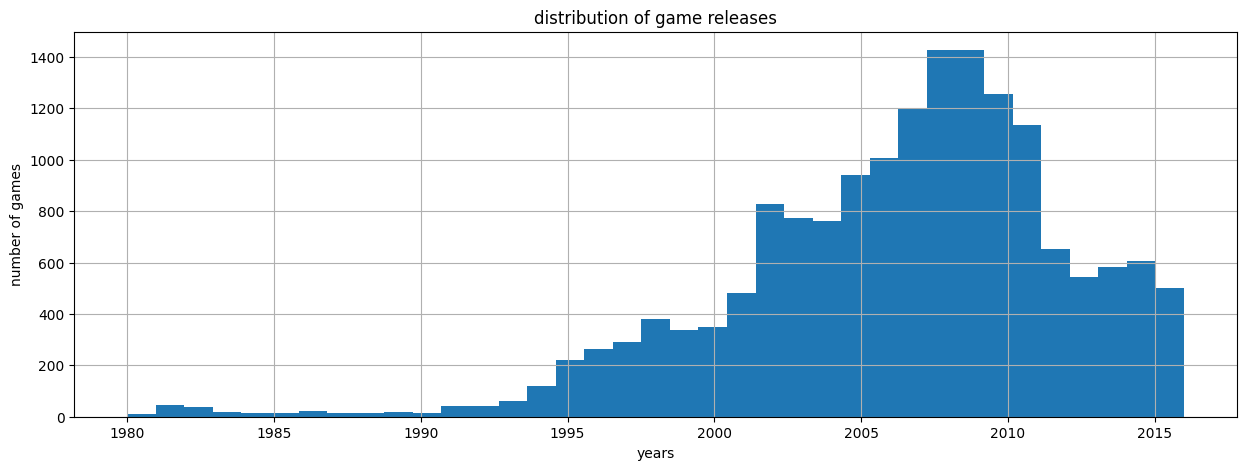

In [23]:
games['year_of_release'].hist(bins=37, grid=True, figsize=(15,5));
plt.title('distribution of game releases');
plt.xlabel('years');
plt.ylabel('number of games');

The largest number of games were released in 2007-2008 (almost 1500 per year); after 2011, about 600 games per year were released consistently. They will probably be replaced by new computer gaming technologies

In [24]:
games['year_of_release'].value_counts()

year_of_release
2008    1427
2009    1426
2010    1255
2007    1197
2011    1136
2006    1006
2005     939
2002     829
2003     775
2004     762
2012     653
2015     606
2014     581
2013     544
2016     502
2001     482
1998     379
2000     350
1999     338
1997     289
1996     263
1995     219
1994     121
1993      60
1981      46
1992      43
1991      41
1982      36
1986      21
1989      17
1983      17
1990      16
1987      16
1988      15
1985      14
1984      14
1980       9
Name: count, dtype: int64

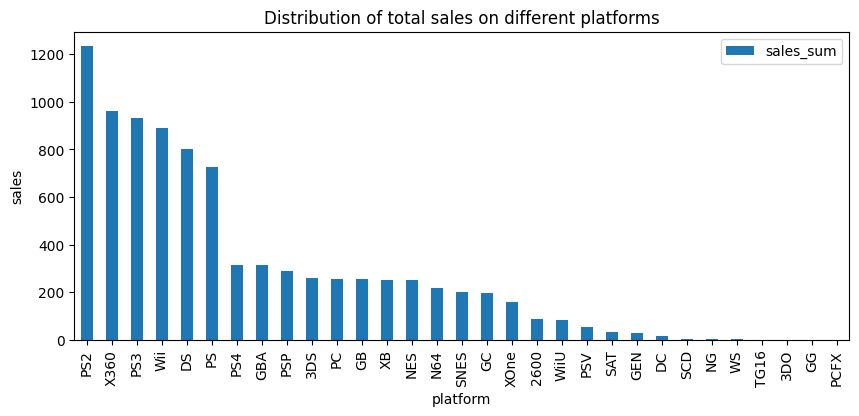

In [25]:
games.pivot_table(index='platform', values='sales_sum', aggfunc='sum').sort_values(by='sales_sum', ascending=False)\
.plot(kind='bar',title='Distribution of total sales on different platforms', ylabel='sales', figsize=(10,4));

So, the first 6 platforms are confident sales leaders - PS2, X360, PS3, Wii, DS and PS. Let's construct a distribution for them by years

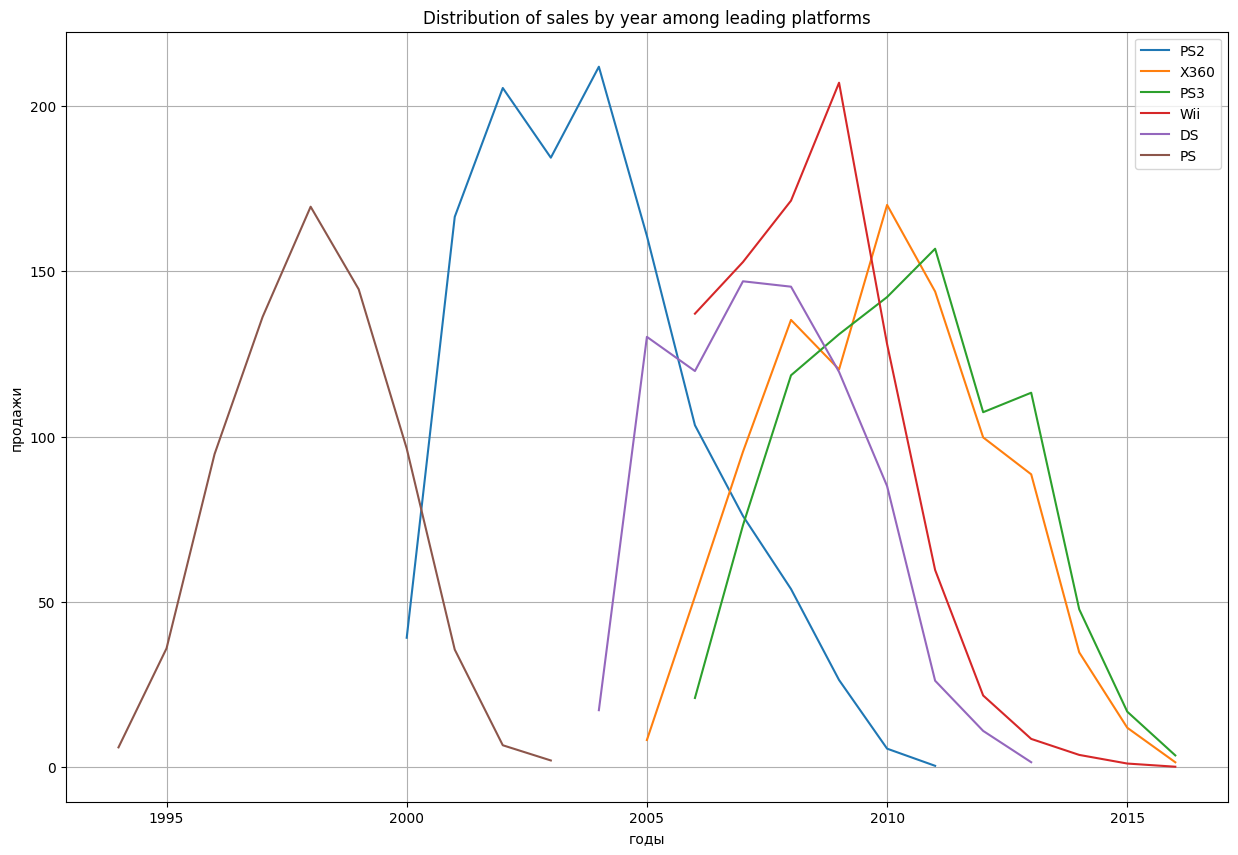

In [26]:
plt.figure(figsize=(15,10))
plt.grid(visible=bool)
plt.plot(games.query('platform=="PS2"').pivot_table(index='year_of_release', values='sales_sum', aggfunc='sum'))
plt.plot(games.query('platform=="X360"').pivot_table(index='year_of_release', values='sales_sum', aggfunc='sum'))
plt.plot(games.query('platform=="PS3"').pivot_table(index='year_of_release', values='sales_sum', aggfunc='sum'))
plt.plot(games.query('platform=="Wii"').pivot_table(index='year_of_release', values='sales_sum', aggfunc='sum'))
plt.plot(games.query('platform=="DS" and year_of_release>1985').pivot_table(index='year_of_release',
                                                                            values='sales_sum', aggfunc='sum'))
plt.plot(games.query('platform=="PS"').pivot_table(index='year_of_release', values='sales_sum', aggfunc='sum'))
plt.xlabel('годы')
plt.ylabel('продажи')
plt.title('Distribution of sales by year among leading platforms')
plt.legend(('PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS'));

Judging by the graph, all our leaders saw the number of game copies sold drop to a minimum by 2016. The graph also shows that the average lifespan of the platform is about 10 years, and sales begin to decline sharply after 5 years of operation. Therefore, for future advertising campaign must be used platforms launched no earlier than 2014.

In [27]:
games_new=games.query('year_of_release>=2014')
games_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1689 entries, 31 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             1689 non-null   object 
 1   platform         1689 non-null   object 
 2   year_of_release  1689 non-null   int64  
 3   genre            1689 non-null   object 
 4   na_sales         1689 non-null   float64
 5   eu_sales         1689 non-null   float64
 6   jp_sales         1689 non-null   float64
 7   other_sales      1689 non-null   float64
 8   critic_score     718 non-null    float64
 9   user_score       888 non-null    float64
 10  rating           940 non-null    object 
 11  sales_sum        1689 non-null   float64
dtypes: float64(7), int64(1), object(4)
memory usage: 171.5+ KB


Let's see which platforms among those launched after 2013 are leading in sales, which are growing, which are falling, and select several potentially profitable platforms

In [28]:
games_new1=games.query('year_of_release>=2014').pivot_table(index='platform', values= 'sales_sum', aggfunc=['count', 'sum', 'median'])
games_new1.columns=['count', 'sum', 'median']
games_new1.sort_values(by='sum', ascending=False)

,count,sum,median
platform,,,
PS4,376,288.15,0.185
XOne,228,140.36,0.205
3DS,212,86.68,0.090
PS3,219,68.18,0.110
X360,111,48.22,0.180
WiiU,73,42.98,0.190
PC,151,27.05,0.060
PSV,295,22.40,0.040
Wii,11,5.07,0.180


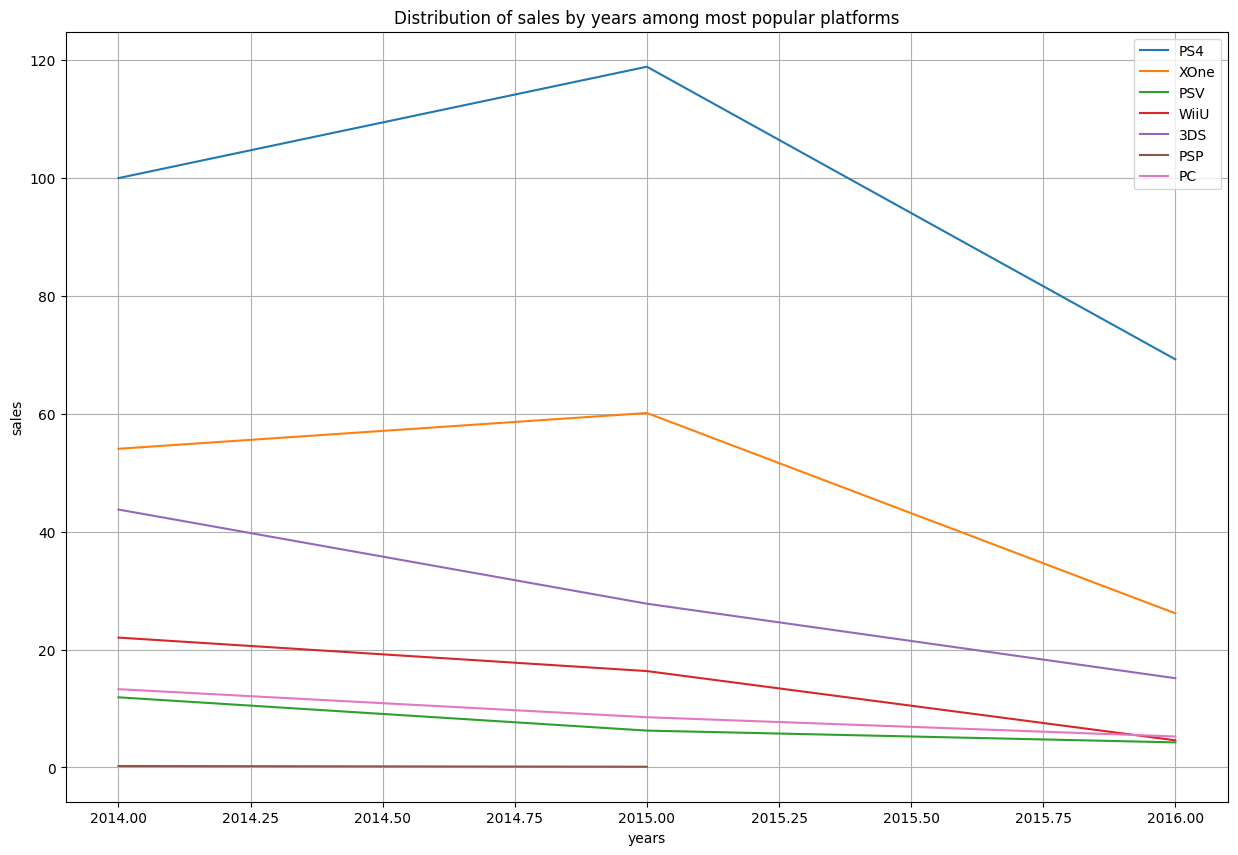

In [29]:
plt.figure(figsize=(15,10))
plt.grid(visible=bool)
plt.plot(games_new.query('platform=="PS4"').pivot_table(index='year_of_release', values='sales_sum', aggfunc='sum'))
plt.plot(games_new.query('platform=="XOne"').pivot_table(index='year_of_release', values='sales_sum', aggfunc='sum'))
plt.plot(games_new.query('platform=="PSV"').pivot_table(index='year_of_release', values='sales_sum', aggfunc='sum'))
plt.plot(games_new.query('platform=="WiiU"').pivot_table(index='year_of_release', values='sales_sum', aggfunc='sum'))
plt.plot(games_new.query('platform=="3DS"').pivot_table(index='year_of_release', values='sales_sum', aggfunc='sum'))
plt.plot(games_new.query('platform=="PSP"').pivot_table(index='year_of_release', values='sales_sum', aggfunc='sum'))
plt.plot(games_new.query('platform=="PC"').pivot_table(index='year_of_release', values='sales_sum', aggfunc='sum'))
plt.xlabel('years')
plt.ylabel('sales')
plt.title('Distribution of sales by years among most popular platforms')
plt.legend(('PS4', 'XOne', 'PSV', 'WiiU', '3DS', 'PSP', 'PC'));

Two leading platforms for the future advertising campaign have emerged (PS4 and XOne). To clarify the information, we will build a graph of global game sales broken down by platforms included in the new dataset

In [30]:
games_new['sales_sum'].describe()

count    1689.000000
mean        0.431883
std         1.056109
min         0.010000
25%         0.030000
50%         0.100000
75%         0.350000
max        14.630000
Name: sales_sum, dtype: float64

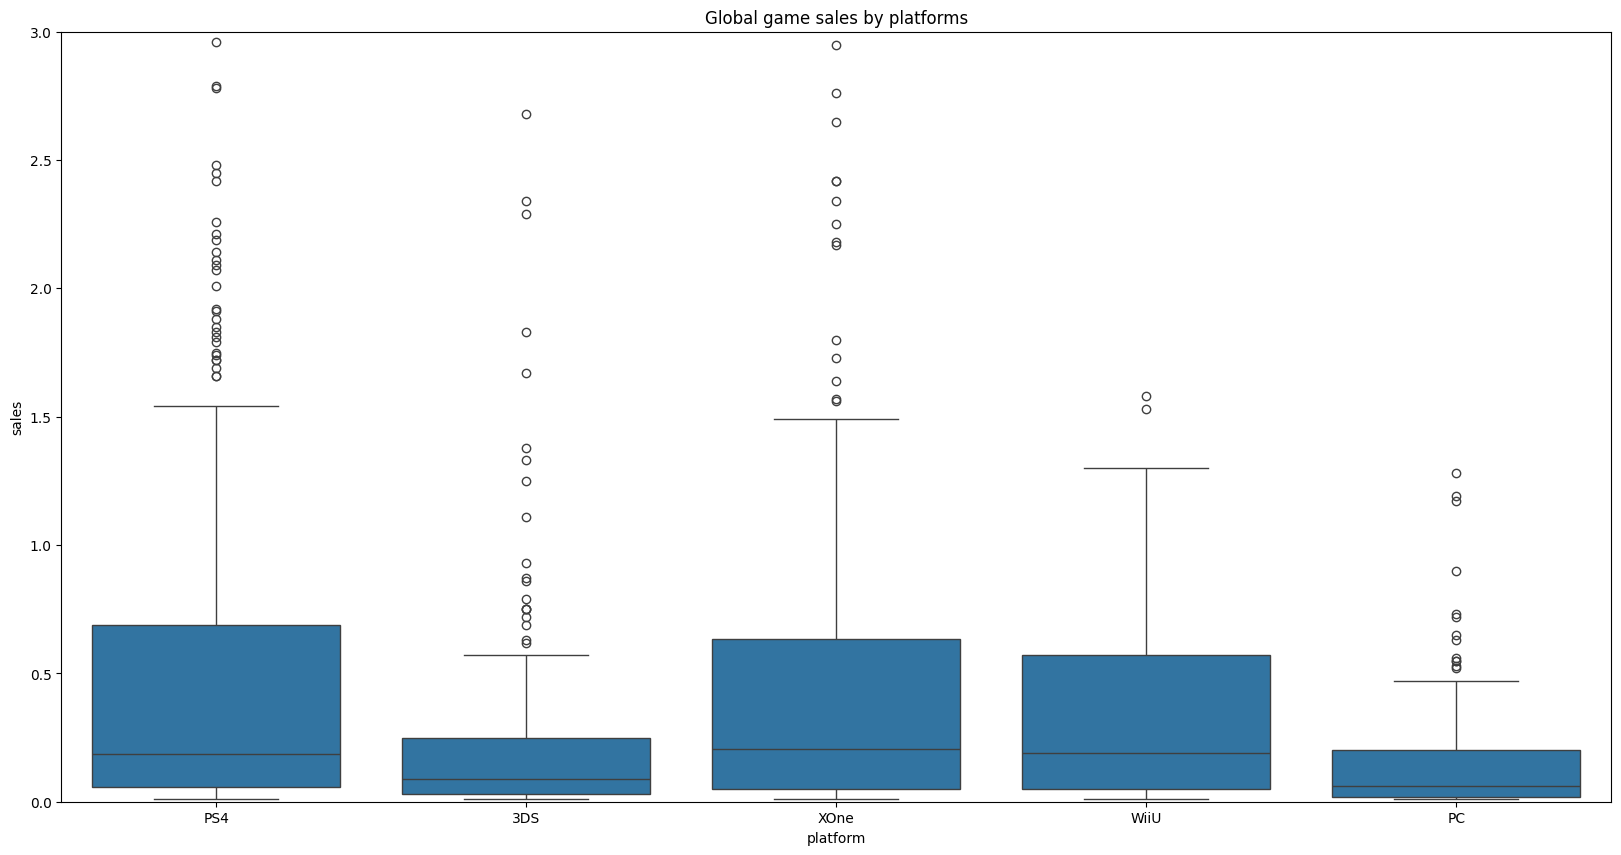

In [31]:
t=games_new.query('platform in ["PS4","XOne","WiiU","3DS","PC"]')
plt.figure(figsize=(20,10));plt.ylim(0, 3);
sns.boxplot(data=t, x='platform', y='sales_sum');plt.title('Global game sales by platforms');
plt.xlabel('platform');plt.ylabel('sales');

The spread of data is very large across all platforms, but among the new platforms we are interested in, the sales leaders are the same - XOne and PS4. The graph also shows that the median sales are highest for the XOne, slightly less for the PS4 and WiiU.

Let's look the correlation between sales and reviews

In [32]:
t=games_new.query('platform=="PS4"')

In [33]:
t['sales_sum'].corr(t['critic_score']).round(2)

0.4

The correlation with critics’ reviews is direct and of medium strength.

In [34]:
t['sales_sum'].corr(t['user_score']).round(2)

-0.04

There is minimal correlation with user reviews.

Let's look at the correlation using the example of the platform with the largest number of games in our dataset

In [35]:
t=games_new.query('platform=="XOne"')
t['sales_sum'].corr(t['critic_score']).round(2)

0.43

In [36]:
t['sales_sum'].corr(t['user_score']).round(2)

-0.07

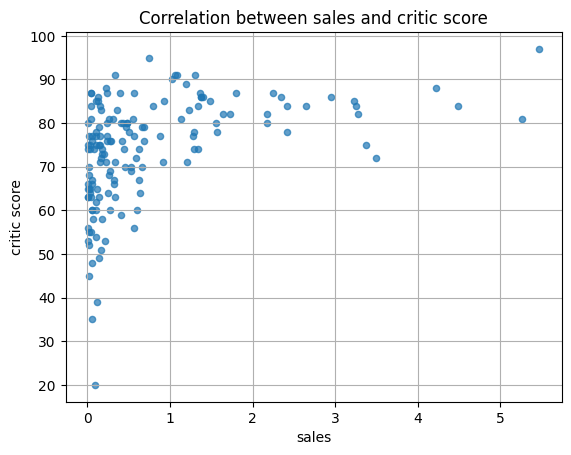

In [37]:
t.plot(x='sales_sum', y='critic_score', kind ='scatter', title='Correlation between sales and critic score',\
       alpha=0.7, grid=True, sharex=False);plt.xlabel('sales');
plt.ylabel('critic score');

the trend continues, we can conclude that user reviews do not affect sales, critic's reviews influence moderately and only at the initial stage of sales (for the first three million copies, then the connection is minimal)

In [38]:
games_new['sales_sum'].corr(games_new['critic_score']).round(2)

0.33

In [39]:
games_new['sales_sum'].corr(games_new['user_score']).round(2)

-0.01

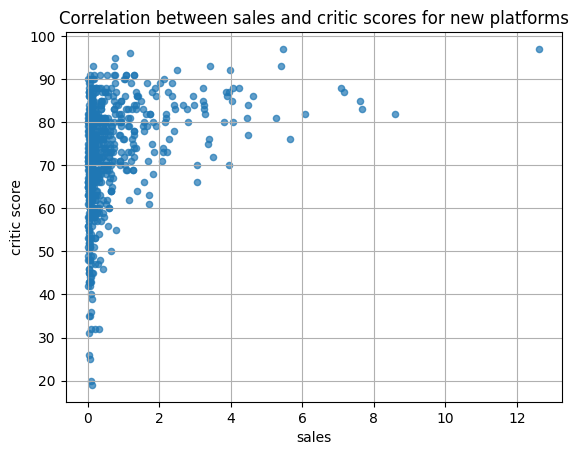

In [40]:
games_new.plot(x='sales_sum', y='critic_score', kind ='scatter', title='Correlation between sales and critic scores for new platforms',\
       alpha=0.7, grid=True, sharex=False);plt.xlabel('sales');
plt.ylabel('critic score');

For a dataset with new platforms, the dependencies are generally the same.

Let's look at the general distribution of games by genre and highlight the most profitable ones. Let's check whether genres with high and low sales stand out.

In [41]:
games_to_genres = games_new.pivot_table(index='genre', values='sales_sum',\
                      aggfunc=['count', 'sum', 'mean']).sort_values(by=('mean','sales_sum'), ascending=False)
games_to_genres.columns = ['number of games', 'number of copies sold', 'average number of copies sold per game']
games_to_genres

,number of games,number of copies sold,average number of copies sold per game
genre,,,
Shooter,128,170.94,1.335469
Sports,161,109.48,0.680000
Platform,38,18.09,0.476053
Fighting,60,28.22,0.470333
Role-Playing,221,101.44,0.459005
Racing,69,27.52,0.398841
Misc,113,37.55,0.332301
Action,619,199.36,0.322068
Simulation,44,13.13,0.298409


The most popular genre in terms of the number of copies sold per game is Shooter; the top three also include Sports and Platform; the most unpopular are Adventure, Strategy, and Puzzle

**Conclusions from the exploratory analysis:**

1. The largest number of games were released in 2007-2008 (almost 1500 per year); after 2011, about 600 games per year were released consistently. They are probably being replaced by new computer gaming technologies.

2. The sales leaders for the entire observation period are 6 platforms - PS2, X360, PS3, Wii, DS and PS. The distribution analysis showed that for all leaders the number of sales became close to zero by 2016. That is, to plan an advertising campaign, you need to place your bet on other, newer platforms. It has also been determined that the average lifespan of a platform is about 12 years, and sales begin to decline sharply after 5-6 years of operation. That is, we need platforms launched no earlier than 2011.

3. As a result of data analysis, two leading platforms for the future advertising campaign were identified (PS4 and XOne). A study of game sales by platform showed that the spread of data is very large across all platforms, but among the new platforms we are interested in, the sales leaders are the same - XOne and PS4.

4. A study of the correlation between sales and reviews for games showed that user reviews do not affect sales, critic reviews have a moderate effect and only at the initial stage of sales (for the first three million copies, then the relationship is minimal). The data is similar for both leaders and the dataset as a whole.

5. The most popular genre in terms of the number of copies sold per game is Shooter, the top three also include Platform and Sports, the most unpopular are Adventure, Puzzle and Strategy.

*4. User profile for each region*

In this part of the project we define for the user of each region (NA, EU, JP):

1.The most popular platforms (top 5). Let us describe the differences in sales shares.

2.The most popular genres (top 5).

3.Does the ESRB rating affect sales in a particular region?

*First, let's look at the popularity of platforms by region*

In [42]:
games_new.pivot_table(index='platform', values=['na_sales', 'eu_sales', 'jp_sales','other_sales'], aggfunc='sum')

,eu_sales,jp_sales,na_sales,other_sales
platform,,,,
3DS,16.12,44.24,22.64,3.68
PC,17.97,0.00,7.23,1.85
PS3,25.54,11.22,22.05,9.37
PS4,130.04,15.02,98.61,44.48
PSP,0.00,0.36,0.00,0.00
PSV,3.53,14.54,2.52,1.81
Wii,2.59,0.00,2.08,0.40
WiiU,13.15,7.31,19.36,3.16
X360,15.49,0.08,28.30,4.35


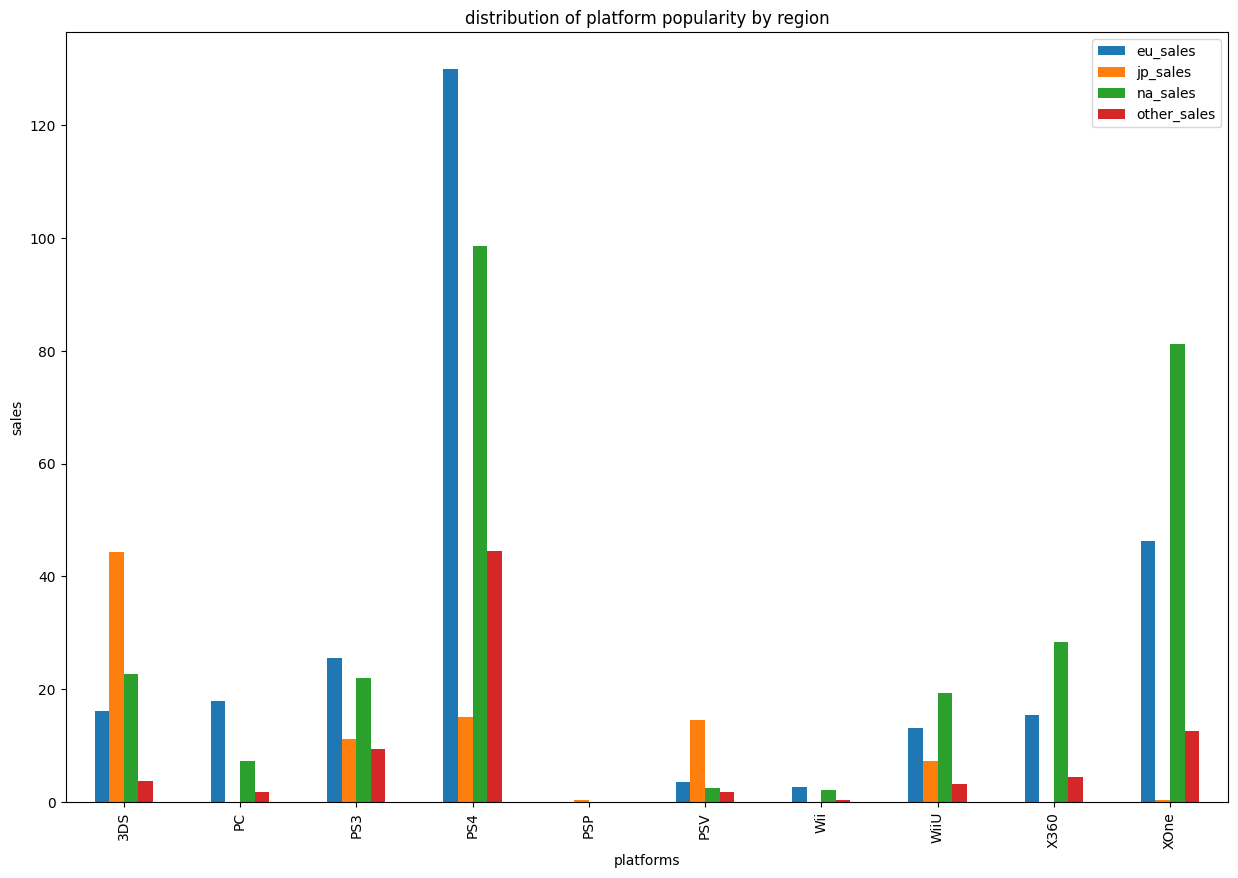

In [43]:
games_new.pivot_table(index='platform', values=['na_sales', 'eu_sales', 'jp_sales','other_sales'], \
                      aggfunc='sum').plot.bar(title='distribution of platform popularity by region',\
                                            xlabel='platforms', ylabel='sales', figsize=(15,10));

The graph across all regions shows differences in user preferences across individual platforms across regions. Let's now look at each region separately.

In [44]:
games_sales_na=games_new.groupby('platform')['na_sales'].sum().sort_values(ascending=False)
games_sales_na=pd.concat([games_sales_na[:5], pd.Series(games_sales_na[5:].sum(), index=['other platforms'])])
games_sales_na

PS4                98.61
XOne               81.27
X360               28.30
3DS                22.64
PS3                22.05
other platforms    31.19
dtype: float64

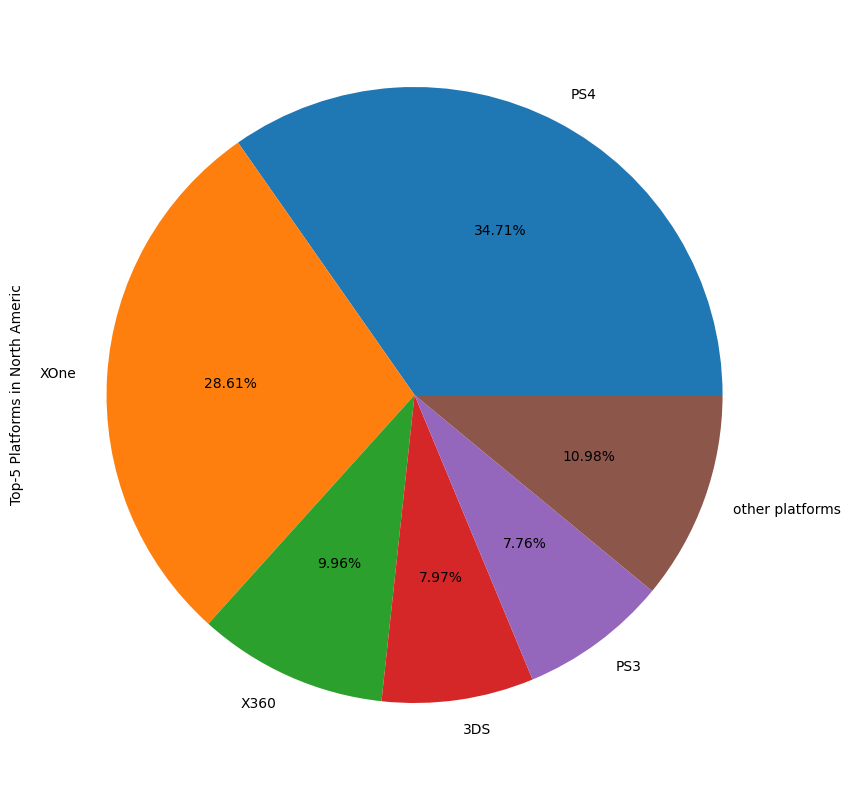

In [45]:
games_sales_na.plot(kind='pie', ylabel='Top-5 Platforms in North Americ', autopct='%1.2f%%',  figsize=(15,10));

In North America, the main leader among platforms is PS4 (34,7% продаж),
in second place XOne (28,6%), Top-5 also includes Х360 (9,9%), 3DS (7,9%) and PS3 (7,7%)

In [46]:
games_sales_eu=games_new.groupby('platform')['eu_sales'].sum().sort_values(ascending=False)
games_sales_eu=pd.concat([games_sales_eu[:5], pd.Series(games_sales_eu[5:].sum(), index=['other platforms'])])
games_sales_eu

PS4                130.04
XOne                46.25
PS3                 25.54
PC                  17.97
3DS                 16.12
other platforms     34.76
dtype: float64

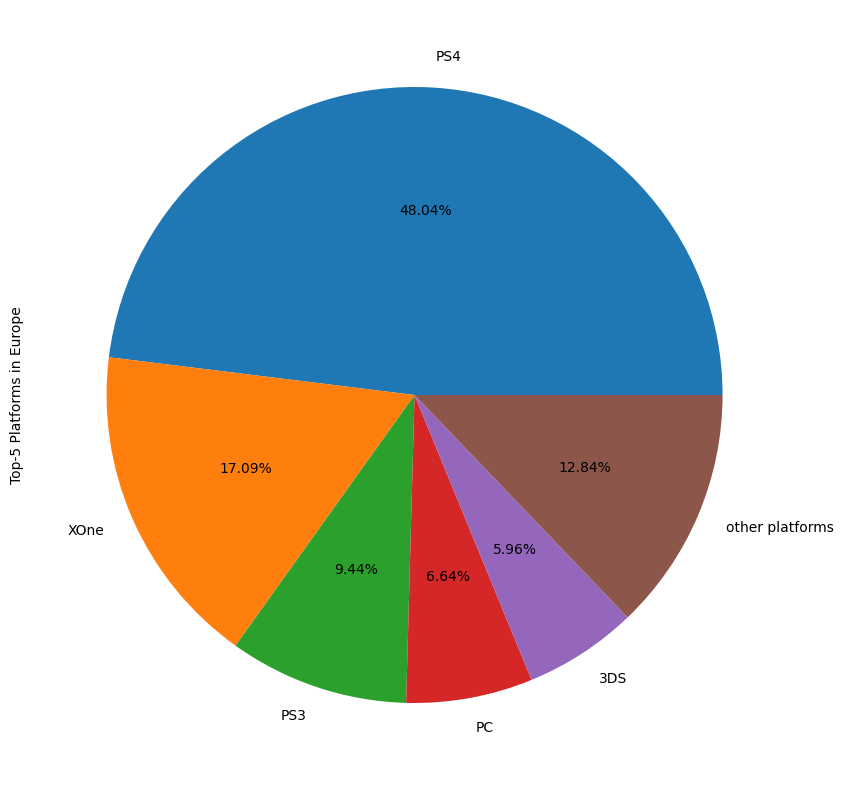

In [47]:
games_sales_eu.plot(kind='pie', ylabel='Top-5 Platforms in Europе', autopct='%1.2f%%',  figsize=(15,10));

In Europe the main leader among platforms is also PS4 (48% продаж), in the second place is XOne (17%), Top-5 Also inclides PS3 (9,4%), PC (6,6%) and 3DS (5,9%)

In [48]:
games_sales_jp=games_new.groupby('platform')['jp_sales'].sum().sort_values(ascending=False)
games_sales_jp=pd.concat([games_sales_jp[:5], pd.Series(games_sales_jp[5:].sum(), index=['other platforms'])])
games_sales_jp

3DS                44.24
PS4                15.02
PSV                14.54
PS3                11.22
WiiU                7.31
other platforms     0.76
dtype: float64

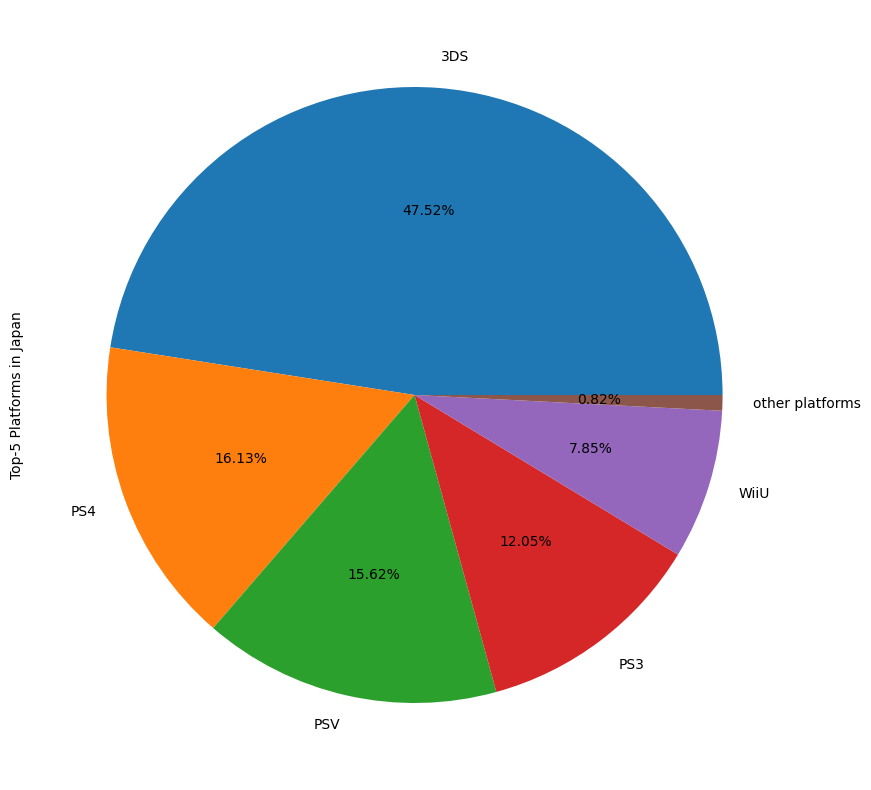

In [49]:
games_sales_jp.plot(kind='pie', ylabel='Top-5 Platforms in Japan', autopct='%1.2f%%',  figsize=(15,10));

In Japan, the main leader among platforms is 3DS (47,5% продаж), in the second place PS4 (16%), Top-5 also includes PSV (15.6%), PS3 (12%) and WiiU (7.8%)

In [50]:
games_sales_other=games_new.groupby('platform')['other_sales'].sum().sort_values(ascending=False)
games_sales_other=pd.concat([games_sales_other[:5], pd.Series(games_sales_other[5:].sum(), index=['other platforms'])])
games_sales_other

PS4                44.48
XOne               12.52
PS3                 9.37
X360                4.35
3DS                 3.68
other platforms     7.22
dtype: float64

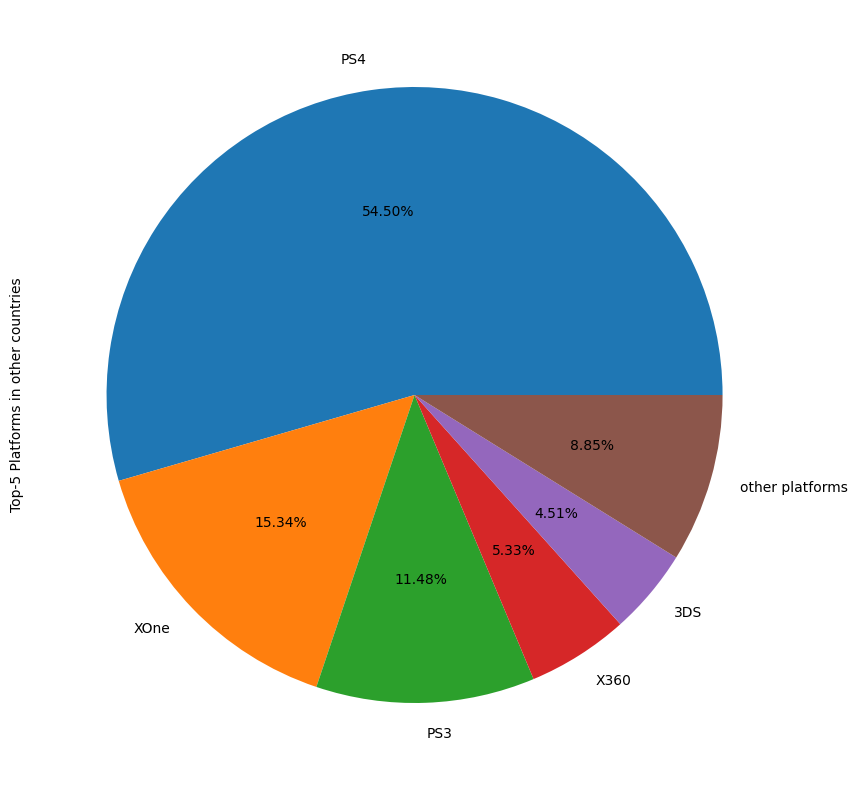

In [51]:
games_sales_other.plot(kind='pie', ylabel='Top-5 Platforms in other countries', autopct='%1.2f%%',  figsize=(15,10));

In other countries, the main leader among platforms is PS4 - it accounts for more than half of all sales (54,5%), in the second place XOne (15,3%), Top-5 also includes PS3 (11,5%), Х360 (5,3%) and 3DS (4,5%)

*Research of most popular genres in each region.*

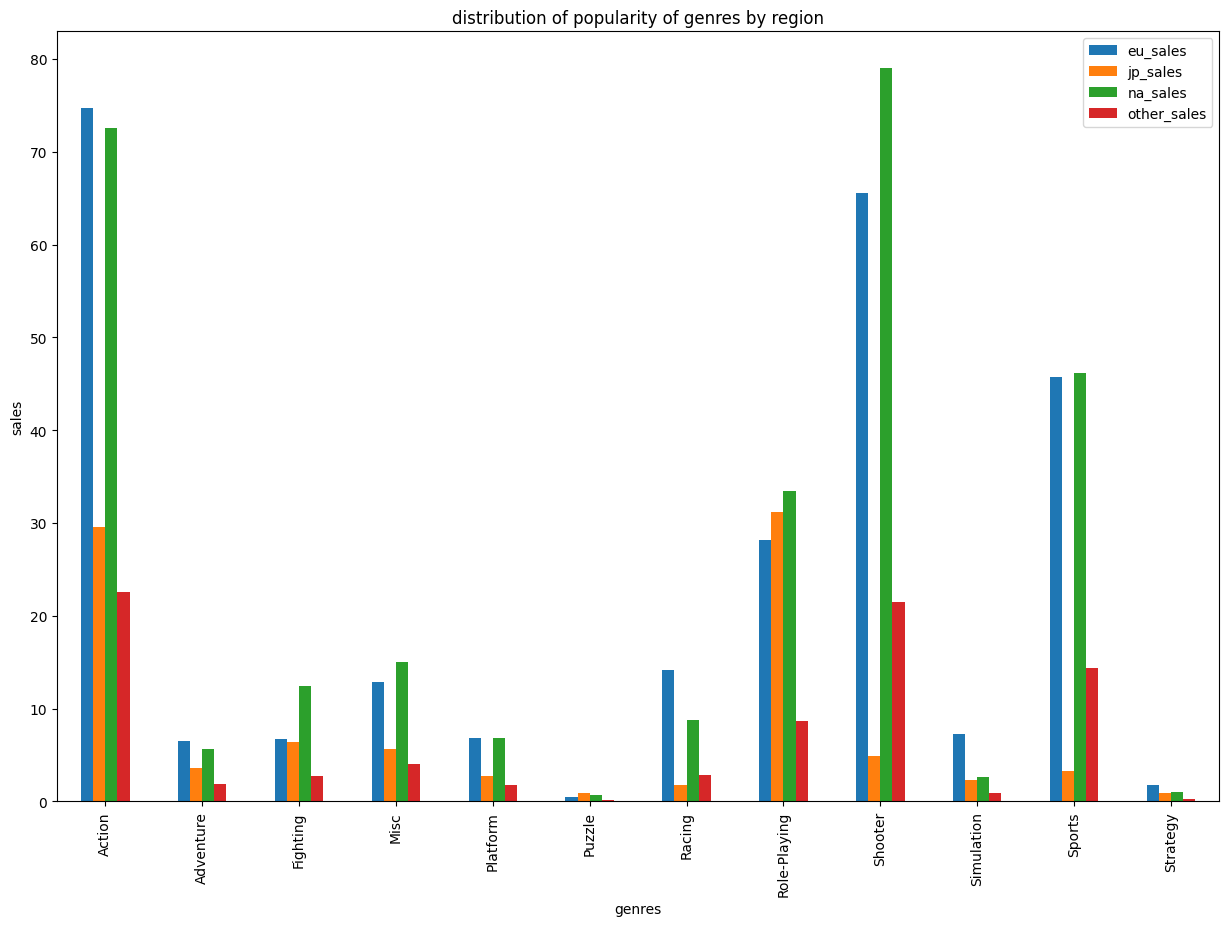

In [52]:
games_new.pivot_table(index='genre', values=['na_sales', 'eu_sales', 'jp_sales','other_sales'], \
                      aggfunc='sum').plot.bar(title='distribution of popularity of genres by region',\
                                            xlabel='genres', ylabel='sales', figsize=(15,10));

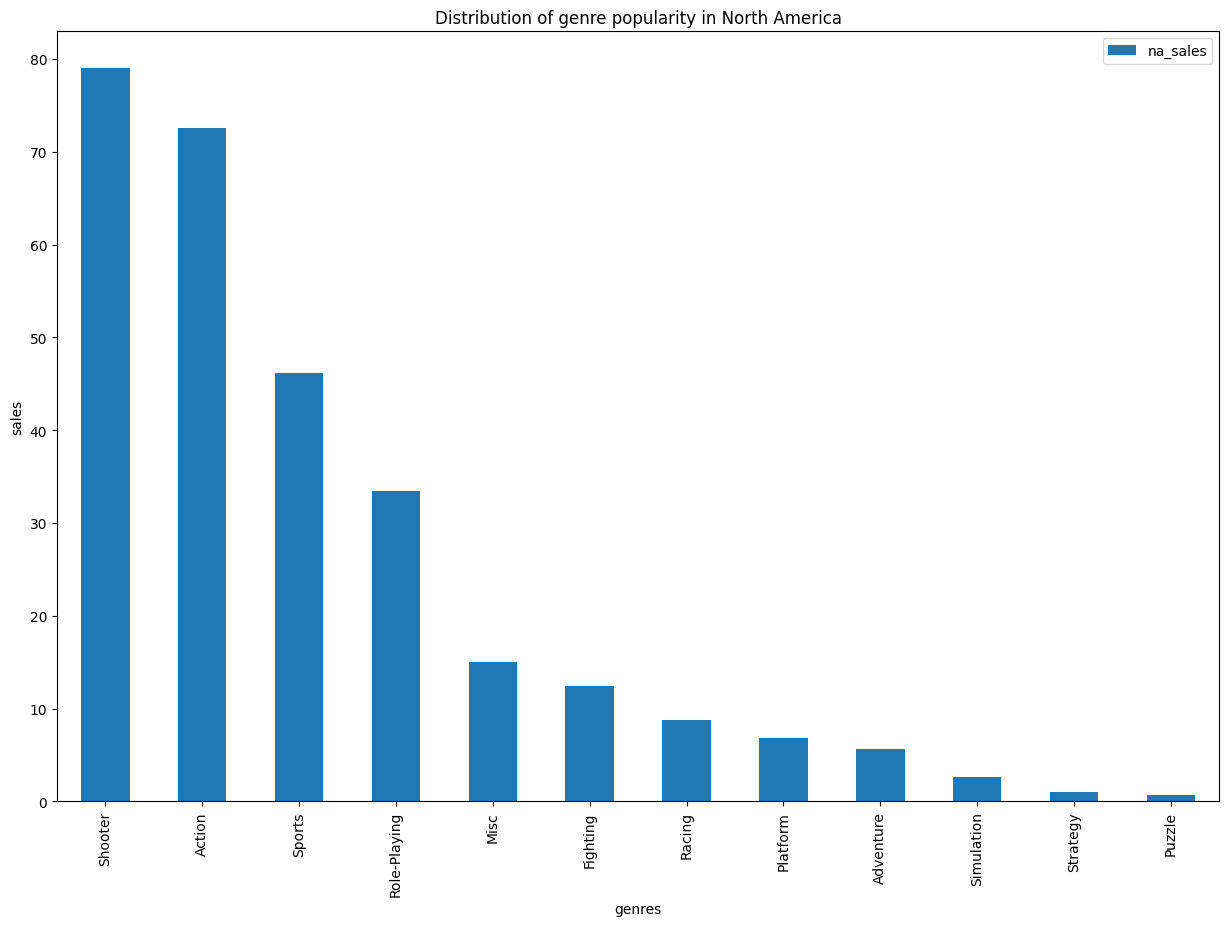

In [53]:
games_new.pivot_table(index='genre', values='na_sales', aggfunc='sum').sort_values(by='na_sales', ascending=False). plot.bar\
(title='Distribution of genre popularity in North America', xlabel='genres', ylabel='sales', figsize=(15,10));

In North America, the top 5 preferred game genres include Shooter, Action, Sports, Role-Playing and Misc.



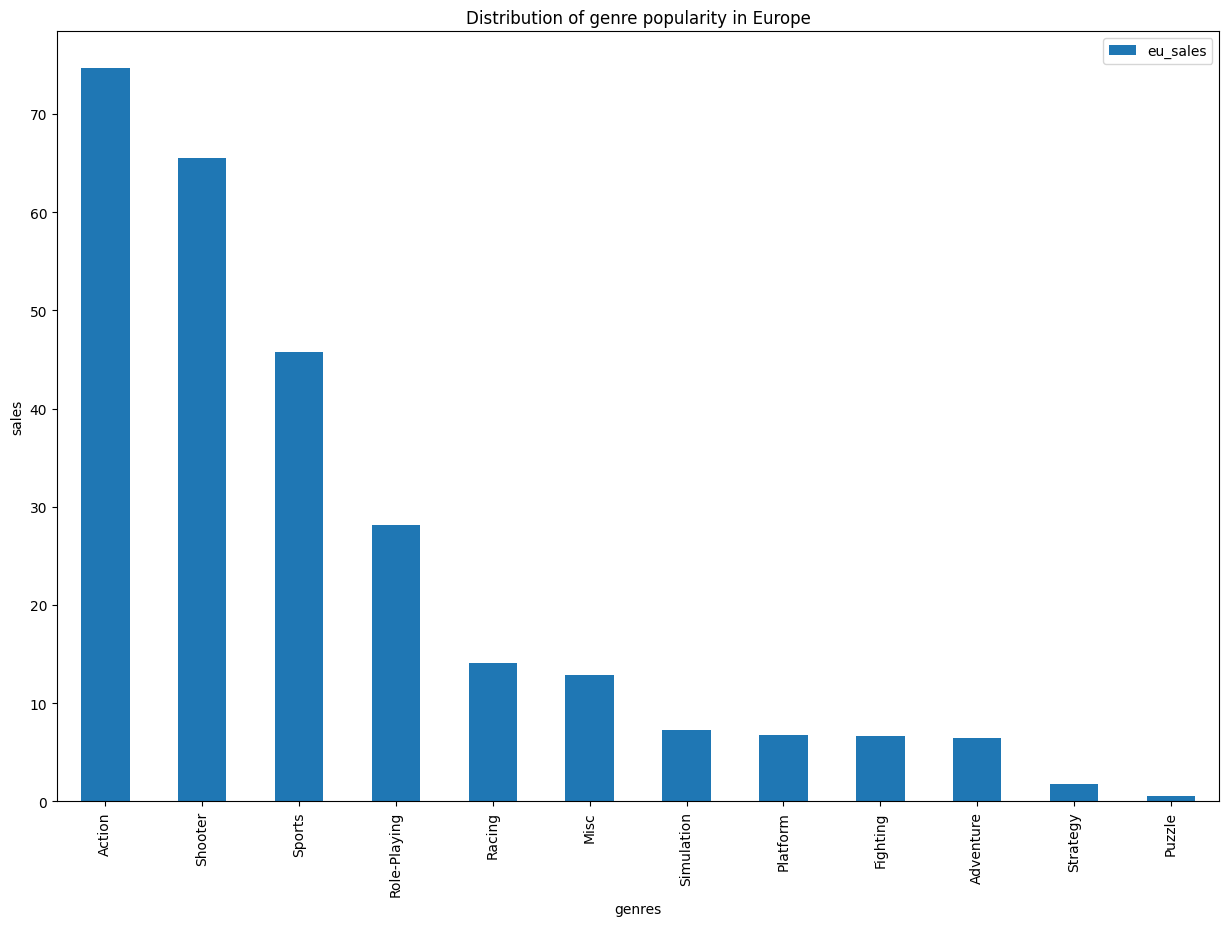

In [54]:
games_new.pivot_table(index='genre', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales', ascending=False). plot.bar\
(title='Distribution of genre popularity in Europe', xlabel='genres', ylabel='sales', figsize=(15,10));

In Europe, the top 5 genres include Action, Shooter, Sports, Role-Playing and Racing

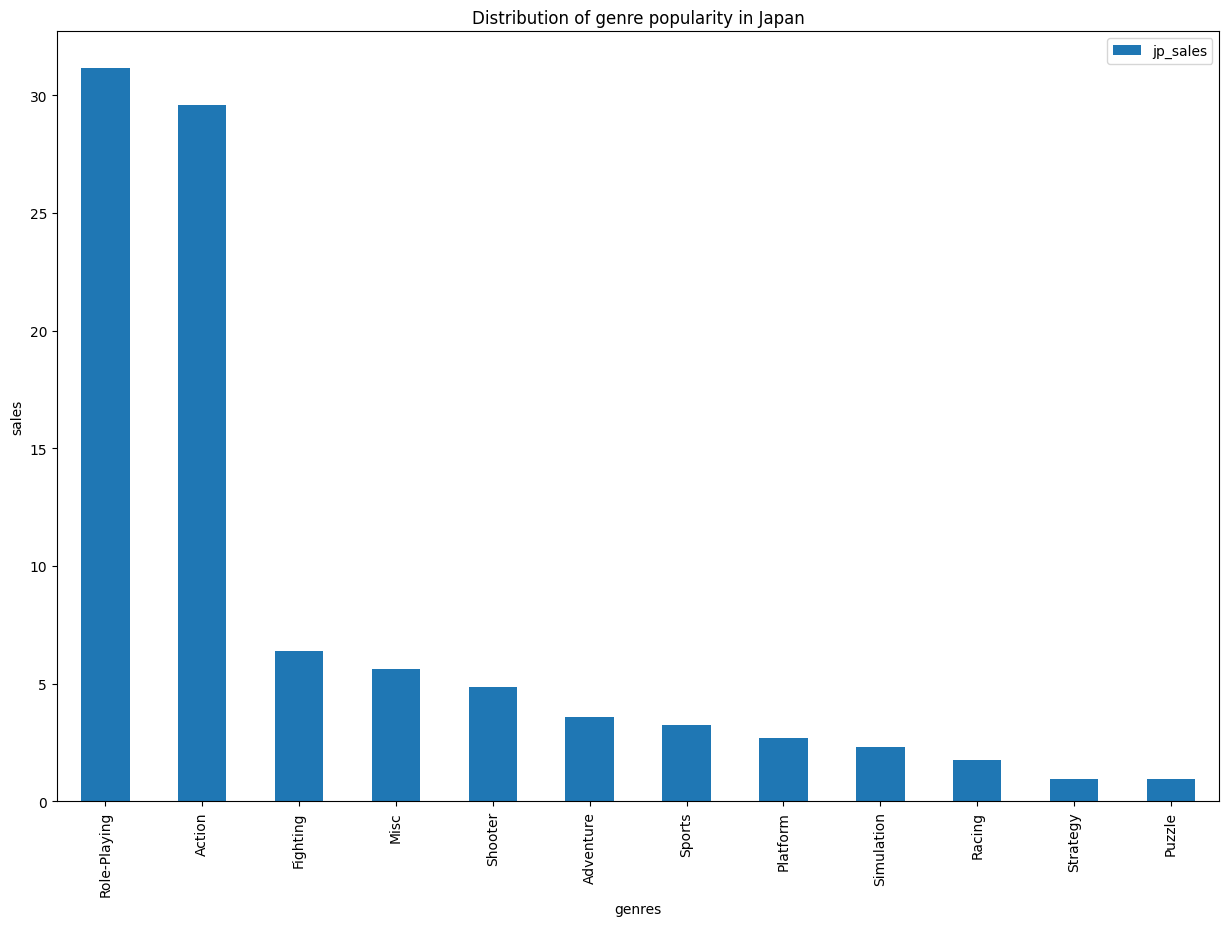

In [55]:
games_new.pivot_table(index='genre', values='jp_sales',aggfunc='sum').sort_values(by='jp_sales', ascending=False). plot.bar\
(title='Distribution of genre popularity in Japan', xlabel='genres', ylabel='sales', figsize=(15,10));

In Japan, the top 5 genres include Role-Playing, Action, Fighiting, Misc and Shooter

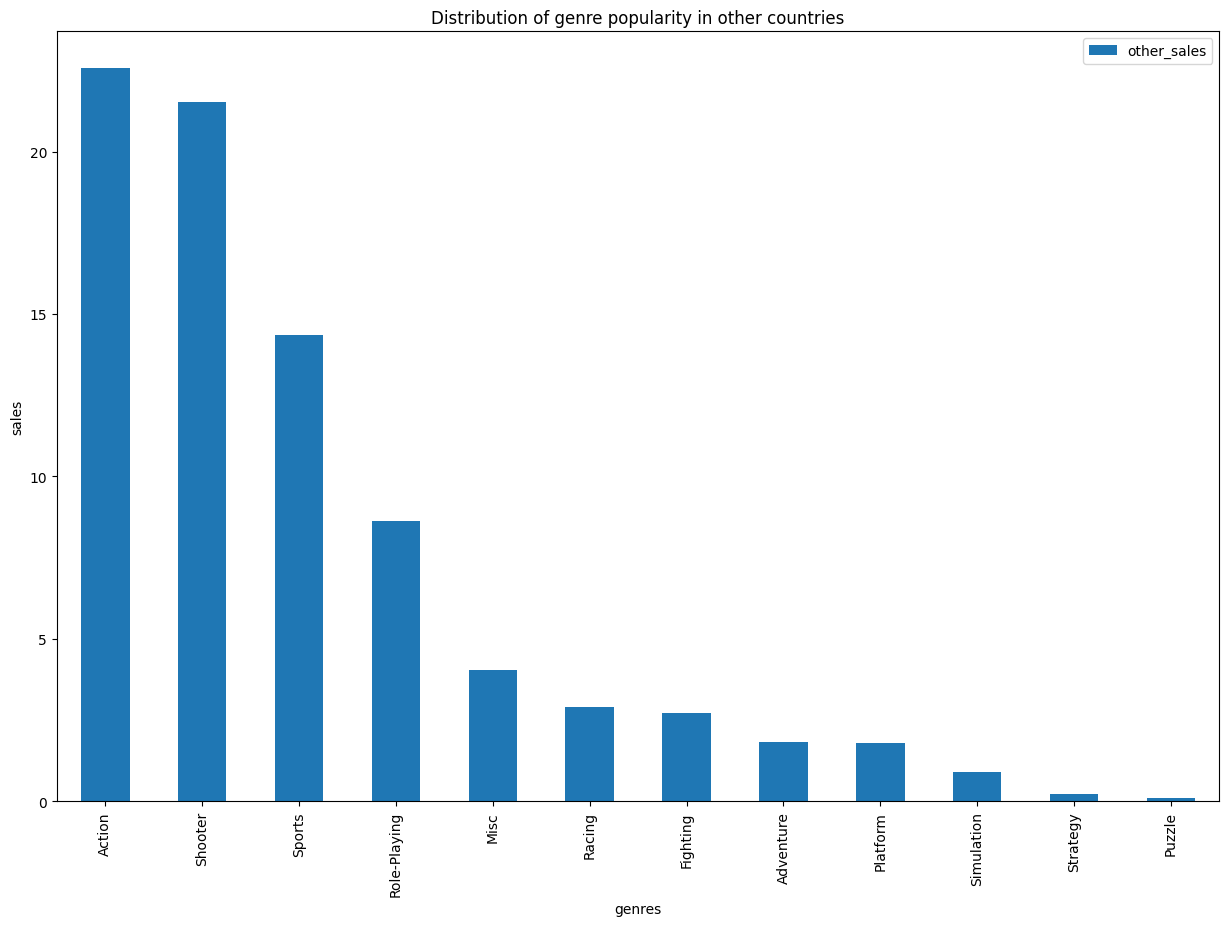

In [56]:
games_new.pivot_table(index='genre', values='other_sales', aggfunc='sum').sort_values(by='other_sales', ascending=False). \
plot.bar(title='Distribution of genre popularity in other countries', xlabel='genres', ylabel='sales', figsize=(15,10));

In other countries, the top 5 includes Action, Shooter, Sports, Role-Playing and Misc.

Differences in the popularity of genres may be due to the prevalence in the region of the platforms for which games of that genre are created.

Let's check this theory

In [57]:
games_new.query('platform=="PS4"').pivot_table(index='genre', values='name',
                                               aggfunc='count').sort_values(by='name', ascending=False)

,name
genre,
Action,142
Role-Playing,51
Sports,42
Shooter,38
Adventure,28
Misc,19
Racing,18
Fighting,17
Platform,9


In [58]:
games_new.query('platform=="3DS"').pivot_table(index='genre', values='name',
                                               aggfunc='count').sort_values(by='name', ascending=False)

,name
genre,
Action,87
Role-Playing,41
Adventure,21
Misc,20
Simulation,10
Platform,8
Strategy,8
Puzzle,7
Fighting,5


The theory seems to be correct: the more games a certain genre is released by the most popular platform in a region, the greater the sales of that genre in the region

*Influence of ESRB rating  on sales in a particular region*

In [59]:
games_new.pivot_table(index='rating', values=['na_sales', 'eu_sales', 'jp_sales','other_sales'], aggfunc='sum')

,eu_sales,jp_sales,na_sales,other_sales
rating,,,,
E,58.06,8.94,50.74,15.39
E10+,26.16,4.46,33.23,7.83
M,93.44,8.01,96.42,28.67
T,34.07,14.78,38.95,11.33


In Europe, North America and other countries the largest sales are for games rated M, in Japan - those rated T. As we remember, according to the ESRB system, games are ranked by age categories of users. E - suitable for everyone, EU - for the youngest, E 10+ from 10 years old, T from 13 years old, M from 17 years old, AO for adults.

We can check the distribution of games by ratings on 2 platforms - PS4 as the most popular in most regions and 3DS as the most popular in Japan.

In [60]:
games_new.query('platform=="PS4"').pivot_table(index='rating', values='name', aggfunc='count')

,name
rating,
E,49
E10+,34
M,72
T,85


In [61]:
games_new.query('platform=="3DS"').pivot_table(index='rating', values='name', aggfunc='count')

,name
rating,
E,26
E10+,30
M,3
T,15


As we can see, PS4 releases quite a lot of games for both adults and teenagers, but in principle it is universal, and there are also a lot of games for everyone and for the little ones. The 3DS practically does not release games 17+, while the majority of games are for children 10+, in second place are games for everyone, in 3rd place for teenagers. Since teenagers can play all types of games, the bet in Japan is clearly made for them as the main audience.

**Section conclusion:**

1. In North America, the main leader among platforms is PS4 (34.7% of sales), XOne is in second place (28.6%), the top 5 also includes X360 (9.9%), 3DS (7.9%) and PS3 (7.7%), in Europe the main leader among platforms is also PS4 with an even greater advantage (48% of sales), XOne is in second place (17%), the top 5 also includes PS3 (9.4%), PC (6.6%) and 3DS (5.9%). In Japan, the 3DS dominates (47.5% of sales), the PS4 is in second place (16%), the top 5 also includes PSV (15.6%), PS3 (12%) and WiiU (7.8%). In other countries, the main leader among platforms is PS4 - it provides more than half of all sales (54.5%), XOne is in second place (15.3%), the top 5 also includes PS3 (11.5%), X360 (5 .3%) and 3DS (4.5%).

2. In North America, the top 5 preferred game genres include Shooter, Action, Sports, Role-Playing and Misc, in Europe Action, Shooter, Sports, Role-Playing and Racing, in Japan Role-Playing, Action, Fighiting, Misc and Shooter , in other countries Action, Shooter, Sports, Role-Playing and Misc. Differences in the popularity of genres are most likely related to the prevalence in the region of the platforms for which games of that genre are created.

3. In Europe, North America and other countries, the largest sales are for games rated M, in Japan - those rated T. The analysis showed that the PS4 produces quite a lot of games for both adults and teenagers, but in principle it is universal and has games for everyone And there’s plenty for the little ones too. The 3DS practically does not release games 17+, while the majority of games are for children 10+, in second place are games for everyone, in 3rd place for teenagers. Since teenagers can play all these types of games, Japan is clearly targeting them as the main audience.

*5. Testing hypotheses*

**Hypothesis 1.**
The average user ratings for the Xbox One and PC platforms are the same.

The null hypothesis is that the average user ratings for the Xbox One and PC platforms are the same. An alternative hypothesis would be that the ratings are unequal. We apply a two-tailed T-test for two independent populations to the average user ratings for the two datasets.

In [62]:
games_filt_xone=games_new.query('platform=="XOne"')
games_filt_xone = games_filt_xone.dropna(subset=['user_score'])
games_filt_xone.info()

<class 'pandas.core.frame.DataFrame'>
Index: 165 entries, 165 to 16660
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             165 non-null    object 
 1   platform         165 non-null    object 
 2   year_of_release  165 non-null    int64  
 3   genre            165 non-null    object 
 4   na_sales         165 non-null    float64
 5   eu_sales         165 non-null    float64
 6   jp_sales         165 non-null    float64
 7   other_sales      165 non-null    float64
 8   critic_score     151 non-null    float64
 9   user_score       165 non-null    float64
 10  rating           159 non-null    object 
 11  sales_sum        165 non-null    float64
dtypes: float64(7), int64(1), object(4)
memory usage: 16.8+ KB


In [63]:
games_filt_pc=games_new.query('platform=="PC"')
games_filt_pc = games_filt_pc.dropna(subset=['user_score'])
games_filt_pc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 122 entries, 458 to 16692
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             122 non-null    object 
 1   platform         122 non-null    object 
 2   year_of_release  122 non-null    int64  
 3   genre            122 non-null    object 
 4   na_sales         122 non-null    float64
 5   eu_sales         122 non-null    float64
 6   jp_sales         122 non-null    float64
 7   other_sales      122 non-null    float64
 8   critic_score     115 non-null    float64
 9   user_score       122 non-null    float64
 10  rating           109 non-null    object 
 11  sales_sum        122 non-null    float64
dtypes: float64(7), int64(1), object(4)
memory usage: 12.4+ KB


In [71]:
print('Average user score for games on the XOne platform:', games_filt_xone['user_score'].mean().round(2))
print('Average user score for games on the  PC platform:', games_filt_pc['user_score'].mean().round(2))
results = st.ttest_ind(games_filt_xone['user_score'], games_filt_pc['user_score'])
alpha=0.05
print('p-value:', results.pvalue)
if results.pvalue<alpha:
    print('The null hypothesis about the equality of the average user ratings of the platforms is rejected; there is reason to assert that the average\
    user ratings of the Xbox One and PC platforms are not the same')
else:
    print('It was not possible to reject the null hypothesis; there is reason to assert that the average user ratings for the Xbox One and PC platforms are the same')

Average user score for games on the XOne platform: 6.59
Average user score for games on the  PC platform: 6.3
p-value: 0.10450507919348415
It was not possible to reject the null hypothesis; there is reason to assert that the average user ratings for the Xbox One and PC platforms are the same


**Hypothesis 2.**
Average user ratings for the Action and Sports genres are different

As the null hypothesis, we will take the position that the average user rating of the Action genre is equal to the rating of the Sports genre.
 An alternative hypothesis would be that the Action and Sports ratings are not equal. We again apply a two-tailed T-test for two independent populations to the average user ratings for the two datasets.

In [66]:
games_filt_action=games_new.query('genre=="Action"')
games_filt_action = games_filt_action.dropna(subset=['user_score'])
games_filt_action.info()

<class 'pandas.core.frame.DataFrame'>
Index: 297 entries, 42 to 16692
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             297 non-null    object 
 1   platform         297 non-null    object 
 2   year_of_release  297 non-null    int64  
 3   genre            297 non-null    object 
 4   na_sales         297 non-null    float64
 5   eu_sales         297 non-null    float64
 6   jp_sales         297 non-null    float64
 7   other_sales      297 non-null    float64
 8   critic_score     227 non-null    float64
 9   user_score       297 non-null    float64
 10  rating           287 non-null    object 
 11  sales_sum        297 non-null    float64
dtypes: float64(7), int64(1), object(4)
memory usage: 30.2+ KB


In [67]:
games_filt_sports=games_new.query('genre=="Sports"')
games_filt_sports = games_filt_sports.dropna(subset=['user_score'])
games_filt_sports.info()

<class 'pandas.core.frame.DataFrame'>
Index: 127 entries, 77 to 16643
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             127 non-null    object 
 1   platform         127 non-null    object 
 2   year_of_release  127 non-null    int64  
 3   genre            127 non-null    object 
 4   na_sales         127 non-null    float64
 5   eu_sales         127 non-null    float64
 6   jp_sales         127 non-null    float64
 7   other_sales      127 non-null    float64
 8   critic_score     83 non-null     float64
 9   user_score       127 non-null    float64
 10  rating           123 non-null    object 
 11  sales_sum        127 non-null    float64
dtypes: float64(7), int64(1), object(4)
memory usage: 12.9+ KB


In [70]:
print('Mean user score for genre Action:', games_filt_action['user_score'].mean().round(2))
print('Mean user score for genre Sports:', games_filt_sports['user_score'].mean().round(2))
results = st.ttest_ind(games_filt_action['user_score'], games_filt_sports['user_score'])
print('p-value:', results.pvalue)
if results.pvalue<0.05:
    print('The null hypothesis that the average ratings of games in the Action and Sports genres are equal is rejected; there is reason to assert that the average \
    user ratings of the Action and Sports genres are not equal')
else:
    print('It was not possible to reject the null hypothesis; there is reason to assert that the average user ratings of genres are equal')


Mean user score for genre Action: 6.76
Mean user score for genre Sports: 5.23
p-value: 2.8711147985105864e-19
The null hypothesis that the average ratings of games in the Action and Sports genres are equal is rejected; there is reason to assert that the average     user ratings of the Action and Sports genres are not equal


**Conclusion for the section.**  

 Two hypotheses were tested:

Hypothesis 1. Average user ratings for the Xbox One and PC platforms are the same. Test result: The null hypothesis could not be rejected; there is reason to assert that the average user ratings for the Xbox One and PC platforms are the same.

Hypothesis 2. Average user ratings for the Action and Sports genres are different. Test result: The null hypothesis about the equality of average ratings for games in the Action and Sports genres was rejected; there is reason to assert that the average user ratings for the Action and Sports genres are not equal.

**General conclusion.**

1. Libraries and dataset were loaded, general information about the dataset was assessed, data was processed for gaps and duplicates, where column types needed to be replaced, a column with total revenue was added.

2. The largest number of games were released in 2007-2008 (almost 1500 per year); after 2011, about 600 games per year were released consistently. They are probably being replaced by new computer gaming technologies.

3. The sales leaders for the entire observation period are 6 platforms - PS2, X360, PS3, Wii, DS and PS. The distribution analysis showed that for all leaders the number of sales became close to zero by 2016. It has also been determined that the average lifespan of a platform is about 12 years, and sales begin to decline sharply after 5-6 years of operation.

4. As a result of data analysis, two leading platforms for the future advertising campaign were identified (PS4 and XOne). A study of game sales by platform showed that the spread of data is very large across all platforms, but among the new platforms we are interested in, the sales leaders are the same - XOne and PS4.

5. A study of the correlation between sales and reviews for games showed that user reviews do not affect sales, critic reviews have a moderate effect and only at the initial stage of sales (for the first three million copies, then the relationship is minimal). The data is similar for both leaders and the dataset as a whole.

6. The most popular genre in terms of the number of copies sold per game is Shooter, the top three also include Platform and Sports, the most unpopular are Adventure, Puzzle and Strategy.

7. In North America, the main leader among platforms is PS4 (34.7% of sales), XOne is in second place (28.6%), in Europe the main leader among platforms is also PS4 (48% of sales), XOne is in second place (17% ). In Japan, the 3DS dominates (47.5% of sales), with the PS4 in second place (16%). In other countries, the main leader among platforms is PS4 - it accounts for more than half of all sales (54.5%), followed by XOne (15.3%).

8. In North America, the top 5 preferred game genres include Shooter, Action, Sports, Role-Playing and Misc, in Europe Action, Shooter, Sports, Role-Playing and Racing, in Japan Role-Playing, Action, Fighiting, Misc and Shooter , in other countries Action, Shooter, Sports, Role-Playing and Misc. Differences in the popularity of genres are most likely related to the prevalence in the region of the platforms for which games of that genre are created.

9. In Europe, North America and other countries, the largest sales are for games rated M, in Japan - those rated T. The analysis showed that the PS4 produces quite a lot of games for both adults and teenagers, but in principle it is universal and has games for everyone And there's plenty for the little ones too. The 3DS practically does not release games 17+, while the majority of games are for children 10+, in second place are games for everyone, in 3rd place for teenagers. Since teenagers can play all these types of games, Japan is clearly targeting them as the main audience.

10. Two hypotheses about the equality of user ratings for individual platforms and genres were tested. As a result of the test, it was not possible to reject the null hypothesis that the ratings of the Xbox One and PC platforms are equal; there is reason to assert that the average user ratings of the Xbox One and PC platforms are the same. The null hypothesis that the average ratings of games in the Action and Sports genres are equal is rejected; there is reason to assert that the average user ratings of the Action and Sports genres are not equal.

11. We recommend to plan advertising campaign for this store with a focus on the PS4 platform, as the most popular in Europe and other countries, XOne, as very popular in North America, and 3DS as the most popular in Japan. Among the genres, it is worth paying attention to Shooter, Action, Sports, Role-Playing.